<a href="https://colab.research.google.com/github/tripnv/aphrodite-14/blob/main/xgb_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [72]:
from xgboost import XGBRegressor
from collections import defaultdict

In [73]:
data = pd.read_csv("/content/drive/MyDrive/aphrodite/BTCUSDT-1h-data.csv")

In [74]:
data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'],
      dtype='object')

In [75]:
data = data[["timestamp", "open", "high","low", "close", "volume"]]

#### Calc error

In [76]:
def calc_MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

def calc_MAE(y_true, y_pred):
  return np.mean(abs(np.array(y_true)- np.array(y_pred)))

def calc_RMSE(y_true, y_pred):
  return math.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

#### Prep functions

In [77]:
def add_lag(df, col, lag_limit):
  for lag in range(6, lag_limit + 1, 6):
    df[col + "_lag_" + str(lag)] = df[col].shift(lag)
  return df

In [78]:
def moving_average(df, col, N):
  """Retrospective moving average"""
  mean_list = df[col].rolling(window = N, min_periods=1).mean() 
  std_list = df[col].rolling(window = N, min_periods=1).std()   
    
  # Add one timestep to the predictions
  mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
  std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
  # Append mean_list to df
  df_out = df.copy()
  df_out[col + '_mean'] = mean_list
  df_out[col + '_std' ] = std_list
    
  return df_out



In [79]:
def scale_columns(df, col, N):
  #scale col 
  df[col + "_scaled"] = (df[col] - df["close_mean"]) / df["close_std"]
  
  #scale lagging columns with std and mean at time T
  for column_number in range(N, 0, -6):
    df[col + "_lag_" + str(column_number) + "_scaled"] = \
            (df[col + "_lag_" + str(column_number)] - df["close_mean"]) / df["close_std"]



  return df

#### XGB functions

In [80]:
def recursive_forecasting(model, N, H, prev_vals, prev_mean_val, prev_std_val):
  forecast = prev_vals.copy()

  for n in range(H):
    forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val
    X = defaultdict(list)

    for n in range(N, 0, -6):
      X["close_lag_" + str(n) + "_scaled"] = [forecast_scaled[-n]]
    
    X = pd.DataFrame(X)
    est_scaled = model.predict(X)
    forecast = np.concatenate([forecast, np.array((est_scaled * prev_std_val ) + prev_mean_val).reshape(1,)])
    
    prev_mean_val = np.mean(forecast[-N:])
    prev_std_val = np.std(forecast[-N:])

  return forecast[-H:]

In [81]:
def train_model(X_train_scaled, y_train_scaled, y_test, N, H, prev_vals, prev_mean_vals, prev_std_vals,
                seed=100,
                n_estimators=100,
                max_depth=3,
                learning_rate=0.1,
                min_child_weight=1,
                subsample=1,
                colsample_bytree=1,
                colsample_bylevel=1,
                gamma=0):

  

  model = XGBRegressor(objective="reg:squarederror",
                       seed = seed,
                       n_estimators = n_estimators,
                       max_depth = max_depth,
                       learning_rate = learning_rate,
                       min_child_weight = min_child_weight,
                       subsample = subsample,
                       colsample_bytree = colsample_bytree,
                       colsample_bylevel = colsample_bylevel,
                       gamma = gamma)
  
  model.fit(X_train_scaled, y_train_scaled)

  # Get prediction and scale back to original range
  est = recursive_forecasting(model, N, H, prev_vals, prev_mean_vals, prev_std_vals)

  rmse = calc_RMSE(y_test, est)
  mape = calc_MAPE(y_test, est)
  mae = calc_MAE(y_test, est)

  return rmse, mape, mae, est, y_test, model.feature_importances_

In [144]:
def multiple_runs(df, train_size, N, H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
  #df is prepared(lag, MA, scale) outside this function
  
  features = []
  for col in edited_data.columns:
    if "lag" in col:
      features.append(col)
  print("\n")
  print("Len features: ", len(features))
  print("\n")
  print(features)

  rmse_list = []
  mae_list  = []
  mape_list = []
  preds_dict = {}
  targets = {}

  for i in tqdm(range(train_size, len(df) - H + 1, int(H/2))):
    train = df[i - train_size:i].copy()
    test = df[i:i+H].copy()

    train.dropna(axis = 0, how = "any", inplace = True)

    X_train_scaled = train[features]
    y_train_scaled = train['close_scaled']

    y_test = test["close"]

    prev_vals = train[-N:]["close"].to_numpy()
    prev_mean_val = test.iloc[0]["close_mean"]
    prev_std_val = test.iloc[0]["close_std"]

    rmse, mape, mae, est, t_tst, f = train_model(X_train_scaled, y_train_scaled, y_test, N, H, prev_vals, prev_mean_val, prev_std_val, 
                                          seed = seed,
                                          n_estimators = n_estimators,
                                          max_depth = max_depth,
                                          learning_rate = learning_rate,
                                          min_child_weight = min_child_weight,
                                          subsample = subsample,
                                          colsample_bytree = colsample_bytree,
                                          colsample_bylevel = colsample_bylevel,
                                          gamma = gamma)

    rmse_list.append(rmse)
    mape_list.append(mape)
    mae_list.append(mae)
    preds_dict[i] = est
    targets[i] = t_tst

  return rmse_list, mae_list, mape_list, preds_dict, targets, f

#### naive experimentation

In [13]:
data["target_close"] = data.close.shift(-1)
data

,timestamp,open,high,low,close,volume,target_close
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,4315.32
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,4324.35
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,4349.99
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,4360.69
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,4444.00
...,...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,56247.87
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,56035.79
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786,56113.90
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168,56290.91


In [ ]:
data.dropna(inplace = True)

In [ ]:
data_ = data.copy()

In [ ]:
data_.timestamp = pd.to_datetime(data_.timestamp)
data_.set_index("timestamp", inplace = True)

In [ ]:
train = data_["2019-01-01":"2020-12-31"]
test = data_["2020-12-31":]

In [ ]:
train.describe()

,open,high,low,close,volume,target_close
count,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000,17499.000000
mean,9213.138672,9256.217619,9166.165027,9214.567505,2346.578272,9216.013006
std,3992.348108,4016.773826,3965.353842,3994.903634,2335.042122,3997.483720
min,3366.630000,3386.970000,3349.920000,3366.410000,0.000000,3366.410000
25%,7167.775000,7200.075000,7140.000000,7168.180000,1057.746265,7168.550000
50%,9127.050000,9156.790000,9091.550000,9127.920000,1679.271589,9128.000000
75%,10549.410000,10597.155000,10502.365000,10549.795000,2729.550390,10550.185000
max,29155.240000,29300.000000,28960.170000,29155.250000,47255.762685,29155.250000


In [ ]:
test.describe()

,open,high,low,close,volume,target_close
count,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000,1793.000000
mean,42351.258020,42725.054501,41953.208048,42366.463581,3976.172778,42381.617178
std,8768.367435,8793.796961,8751.079900,8768.541885,2601.475092,8769.115370
min,28371.520000,28523.470000,27850.000000,28371.510000,0.000000,28371.510000
25%,34361.160000,34797.730000,34000.000000,34367.680000,2454.891718,34375.340000
50%,39998.630000,40415.010000,39572.740000,40028.190000,3279.919594,40075.820000
75%,49151.360000,49509.840000,48758.000000,49159.160000,4632.321204,49163.460000
max,61648.260000,61844.000000,61089.980000,61648.260000,32057.769171,61648.260000


In [ ]:
features = [x for x in train.columns]
features.remove("target_close")

In [ ]:
x_train, y_train = train[features], train["target_close"]
x_test, y_test = test[features], test["target_close"]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17499, 5)
(17499,)
(1793, 5)
(1793,)


In [ ]:
from xgboost import XGBRegressor

In [ ]:
def train_model(x_train, y_train, x_test, y_test):  
  model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
  model.fit(x_train, y_train)
  return model

In [ ]:
m = train_model(x_train, y_train, x_test, y_test)

In [ ]:
preds = m.predict(x_test)

In [ ]:
import math

In [ ]:
preds = preds.reshape(-1,1)

In [ ]:
ts = y_test.to_numpy()
ts = ts.reshape(-1,1)

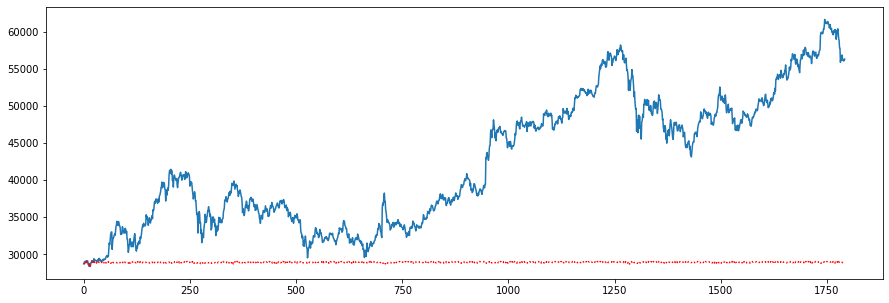

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(ts)
plt.plot(preds, color = "red", ls = ":")

In [ ]:
calc_MAPE(ts, preds)

28.775705731604383

In [ ]:
calc_MAE(ts, preds)

13449.061769685934

w/ lag

In [ ]:
data_w_lag = data_.copy()

In [ ]:
for feature in features:
  data_w_lag = add_lag(data_w_lag, feature, 24)

In [ ]:
data_w_lag.dropna(inplace = True)

In [ ]:
data_w_lag

,open,high,low,close,volume,target_close,open_lag_6,open_lag_12,open_lag_18,open_lag_24,high_lag_6,high_lag_12,high_lag_18,high_lag_24,low_lag_6,low_lag_12,low_lag_18,low_lag_24,close_lag_6,close_lag_12,close_lag_18,close_lag_24,volume_lag_6,volume_lag_12,volume_lag_18,volume_lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:00:00,4292.39,4292.39,4234.43,4287.92,50.797515,4313.56,4333.55,4352.33,4441.10,4261.48,4359.13,4354.35,4470.00,4313.62,4310.00,4255.30,4399.81,4261.32,4336.80,4354.18,4460.00,4308.83,57.376142,67.458791,24.865399,47.181009
2017-08-18 05:00:00,4287.92,4340.62,4250.04,4313.56,64.169286,4279.46,4313.39,4354.18,4460.00,4308.83,4337.38,4354.84,4485.39,4328.69,4280.82,4235.45,4427.30,4291.37,4285.08,4289.24,4427.30,4315.32,81.645263,59.664912,27.018053,23.234916
2017-08-18 06:00:00,4313.56,4316.98,4247.75,4279.46,64.235424,4300.25,4285.08,4289.24,4436.06,4330.29,4340.62,4302.45,4449.56,4345.45,4228.76,4218.68,4411.00,4309.37,4286.53,4256.97,4411.00,4324.35,82.435474,51.275163,23.032398,7.229691
2017-08-18 07:00:00,4279.46,4304.67,4270.48,4300.25,69.186804,4282.73,4269.36,4241.91,4411.00,4316.62,4269.36,4335.30,4459.00,4349.99,4134.61,4200.74,4411.00,4287.41,4243.59,4325.23,4459.00,4349.99,75.684883,46.710850,31.312436,4.443249
2017-08-18 08:00:00,4285.00,4320.71,4259.85,4282.73,74.829849,4304.15,4251.95,4307.56,4459.00,4333.32,4298.64,4354.84,4485.39,4377.85,4234.00,4258.56,4435.93,4333.32,4267.59,4346.74,4470.82,4360.69,54.071337,48.975472,51.735897,0.972807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-15 14:00:00,56855.58,57312.47,56123.12,56134.09,4699.216333,56224.13,57789.75,60066.56,59928.71,59940.00,58350.00,60331.02,60325.98,60477.83,57500.00,60037.61,59702.78,59868.12,57757.70,60069.63,60264.48,60001.91,4975.321732,1776.362134,1677.502893,1950.743605
2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,56247.87,57757.71,60069.63,60264.48,60001.90,58100.00,60491.47,60485.08,60150.00,54600.00,60069.62,59852.18,59470.00,55867.91,60379.99,60081.54,59681.26,16138.467401,1353.807936,1480.961277,2495.615256
2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,56035.79,55871.29,60379.99,60081.55,59681.21,56438.00,60633.43,60324.43,60066.59,55555.55,59658.87,59733.38,59300.00,56355.14,59773.71,60201.19,59567.74,5624.833829,2437.909665,1414.972973,3099.347608


In [ ]:
data_w_lag.columns

Index(['open', 'high', 'low', 'close', 'volume', 'target_close', 'open_lag_6',
       'open_lag_12', 'open_lag_18', 'open_lag_24', 'high_lag_6',
       'high_lag_12', 'high_lag_18', 'high_lag_24', 'low_lag_6', 'low_lag_12',
       'low_lag_18', 'low_lag_24', 'close_lag_6', 'close_lag_12',
       'close_lag_18', 'close_lag_24', 'volume_lag_6', 'volume_lag_12',
       'volume_lag_18', 'volume_lag_24'],
      dtype='object')

In [ ]:
features_lag = [x for x in data_w_lag.columns]
features_lag.remove("target_close")

In [ ]:
train = data_w_lag[:"2020-12-31"]
test = data_w_lag["2020-12-31":]
x_train, y_train = train[features_lag], train["target_close"]
x_test, y_test = test[features_lag], test["target_close"]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(29451, 25)
(29451,)
(1793, 25)
(1793,)


In [ ]:
x_train

,open,high,low,close,volume,open_lag_6,open_lag_12,open_lag_18,open_lag_24,high_lag_6,high_lag_12,high_lag_18,high_lag_24,low_lag_6,low_lag_12,low_lag_18,low_lag_24,close_lag_6,close_lag_12,close_lag_18,close_lag_24,volume_lag_6,volume_lag_12,volume_lag_18,volume_lag_24
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:00:00,4292.39,4292.39,4234.43,4287.92,50.797515,4333.55,4352.33,4441.10,4261.48,4359.13,4354.35,4470.00,4313.62,4310.00,4255.30,4399.81,4261.32,4336.80,4354.18,4460.00,4308.83,57.376142,67.458791,24.865399,47.181009
2017-08-18 05:00:00,4287.92,4340.62,4250.04,4313.56,64.169286,4313.39,4354.18,4460.00,4308.83,4337.38,4354.84,4485.39,4328.69,4280.82,4235.45,4427.30,4291.37,4285.08,4289.24,4427.30,4315.32,81.645263,59.664912,27.018053,23.234916
2017-08-18 06:00:00,4313.56,4316.98,4247.75,4279.46,64.235424,4285.08,4289.24,4436.06,4330.29,4340.62,4302.45,4449.56,4345.45,4228.76,4218.68,4411.00,4309.37,4286.53,4256.97,4411.00,4324.35,82.435474,51.275163,23.032398,7.229691
2017-08-18 07:00:00,4279.46,4304.67,4270.48,4300.25,69.186804,4269.36,4241.91,4411.00,4316.62,4269.36,4335.30,4459.00,4349.99,4134.61,4200.74,4411.00,4287.41,4243.59,4325.23,4459.00,4349.99,75.684883,46.710850,31.312436,4.443249
2017-08-18 08:00:00,4285.00,4320.71,4259.85,4282.73,74.829849,4251.95,4307.56,4459.00,4333.32,4298.64,4354.84,4485.39,4377.85,4234.00,4258.56,4435.93,4333.32,4267.59,4346.74,4470.82,4360.69,54.071337,48.975472,51.735897,0.972807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,28872.24,29000.00,28742.41,28897.83,2293.821339,28617.65,28859.02,29120.50,28510.86,28635.90,29285.00,29177.41,28900.05,27850.00,28859.02,28120.67,28444.00,28519.00,29155.25,28743.57,28776.46,7710.029652,3192.082973,6991.539806,7242.879514
2020-12-31 20:00:00,28897.84,29139.65,28862.00,29126.70,1936.480299,28519.25,29155.24,28743.58,28776.45,28523.47,29210.83,28792.76,28996.00,28111.25,28780.00,28600.38,28603.24,28371.51,28926.31,28720.49,28785.67,3624.618531,3372.849195,1906.355789,4271.327517
2020-12-31 21:00:00,29126.71,29169.55,28900.79,28966.36,2524.473111,28371.52,28926.32,28720.48,28785.67,28840.26,29067.82,29147.75,28980.00,28369.53,28580.00,28711.06,28534.70,28770.00,28989.99,29024.00,28875.21,3793.597205,2954.209454,2583.086498,3551.040384


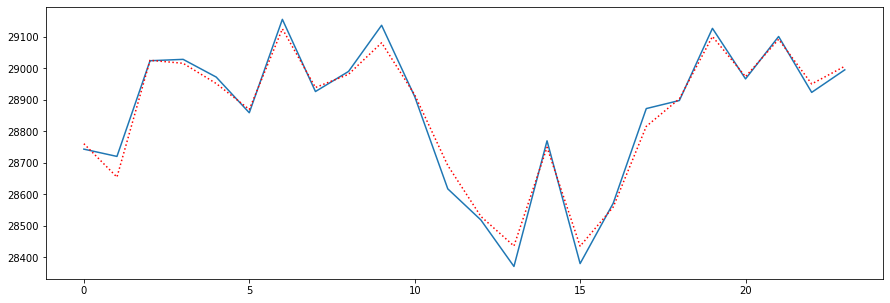

In [ ]:
m = train_model(x_train, y_train, x_test, y_test)
preds = m.predict(x_test)
preds = preds.reshape(-1,1)
ts = y_test.to_numpy()
ts = ts.reshape(-1,1)

calc_MAPE(ts, preds)



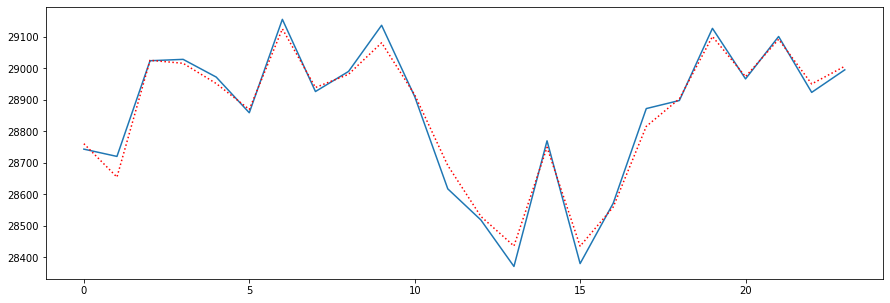

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(ts[:24])
plt.plot(preds[:24], color = "red", ls = ":")

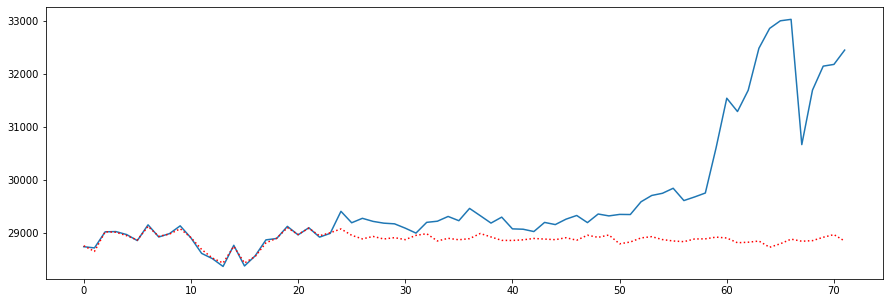

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(ts[:72])
plt.plot(preds[:72], color = "red", ls = ":")

In [ ]:
calc_MAPE(ts[:24], preds[:24])

0.08996706623283965

####Test individual functions

In [103]:
data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [104]:
data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [105]:
features = ["close"]

In [106]:
edited_data = data.copy()

In [107]:
edited_data

,timestamp,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168


In [108]:
for feature in features:
  edited_data = add_lag(edited_data, feature, 24)


In [109]:
edited_data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_lag_6',
       'close_lag_12', 'close_lag_18', 'close_lag_24'],
      dtype='object')

In [110]:
edited_data

,timestamp,open,high,low,close,volume,close_lag_6,close_lag_12,close_lag_18,close_lag_24
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,55867.91,60379.99,60081.54,59681.26
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,56355.14,59773.71,60201.19,59567.74
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786,56150.79,59013.35,58968.31,59701.10
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168,56439.53,58781.49,59404.48,60138.31


In [111]:
edited_data = moving_average(edited_data, "close", 24)

In [112]:
edited_data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_lag_6',
       'close_lag_12', 'close_lag_18', 'close_lag_24', 'close_mean',
       'close_std'],
      dtype='object')

In [113]:
edited_data

,timestamp,open,high,low,close,volume,close_lag_6,close_lag_12,close_lag_18,close_lag_24,close_mean,close_std
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,4308.830000,NaN
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,4312.075000,4.589123
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,4316.166667,7.794564
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,4324.622500,18.069531
...,...,...,...,...,...,...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,55867.91,60379.99,60081.54,59681.26,58723.972500,1589.655997
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,56355.14,59773.71,60201.19,59567.74,58579.925417,1654.453358
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786,56150.79,59013.35,58968.31,59701.10,58441.597500,1706.247346
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168,56439.53,58781.49,59404.48,60138.31,58288.876250,1752.032764


In [114]:
for feature in features:
  edited_data = scale_columns(edited_data, feature, 24)

In [115]:
edited_data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_lag_6',
       'close_lag_12', 'close_lag_18', 'close_lag_24', 'close_mean',
       'close_std', 'close_scaled', 'close_lag_24_scaled',
       'close_lag_18_scaled', 'close_lag_12_scaled', 'close_lag_6_scaled'],
      dtype='object')

In [116]:
edited_data

,timestamp,open,high,low,close,volume,close_lag_6,close_lag_12,close_lag_18,close_lag_24,close_mean,close_std,close_scaled,close_lag_24_scaled,close_lag_18_scaled,close_lag_12_scaled,close_lag_6_scaled
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,NaN,NaN,NaN,NaN,4308.830000,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,NaN,NaN,NaN,NaN,4312.075000,4.589123,2.674803,NaN,NaN,NaN,NaN
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,NaN,NaN,NaN,NaN,4316.166667,7.794564,4.339349,NaN,NaN,NaN,NaN
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,NaN,NaN,NaN,NaN,4324.622500,18.069531,1.996040,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,55867.91,60379.99,60081.54,59681.26,58723.972500,1589.655997,-1.572568,0.602198,0.854001,1.041746,-1.796654
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,56355.14,59773.71,60201.19,59567.74,58579.925417,1654.453358,-1.409563,0.597064,0.979940,0.721558,-1.344725
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786,56150.79,59013.35,58968.31,59701.10,58441.597500,1706.247346,-1.409999,0.738171,0.308696,0.335094,-1.342600
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168,56439.53,58781.49,59404.48,60138.31,58288.876250,1752.032764,-1.241402,1.055593,0.636748,0.281167,-1.055543


In [117]:
for feature in features:
  for c in range(24, 0, -6):
    edited_data.drop([feature + '_lag_' + str(c)], axis=1, inplace=True)

In [118]:
edited_data.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_mean',
       'close_std', 'close_scaled', 'close_lag_24_scaled',
       'close_lag_18_scaled', 'close_lag_12_scaled', 'close_lag_6_scaled'],
      dtype='object')

In [119]:
edited_data

,timestamp,open,high,low,close,volume,close_mean,close_std,close_scaled,close_lag_24_scaled,close_lag_18_scaled,close_lag_12_scaled,close_lag_6_scaled
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916,4308.830000,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691,4312.075000,4.589123,2.674803,NaN,NaN,NaN,NaN
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249,4316.166667,7.794564,4.339349,NaN,NaN,NaN,NaN
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807,4324.622500,18.069531,1.996040,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31240,2021-03-15 15:00:00,56134.09,56816.69,55854.20,56224.13,4402.384401,58723.972500,1589.655997,-1.572568,0.602198,0.854001,1.041746,-1.796654
31241,2021-03-15 16:00:00,56224.14,56700.00,55669.28,56247.87,4462.956112,58579.925417,1654.453358,-1.409563,0.597064,0.979940,0.721558,-1.344725
31242,2021-03-15 17:00:00,56261.02,56331.11,55478.01,56035.79,3315.713786,58441.597500,1706.247346,-1.409999,0.738171,0.308696,0.335094,-1.342600
31243,2021-03-15 18:00:00,56034.82,56377.66,55800.00,56113.90,2345.779168,58288.876250,1752.032764,-1.241402,1.055593,0.636748,0.281167,-1.055543


In [120]:
timestamps = edited_data.timestamp

In [121]:
for col in edited_data.columns:
  if "close" not in col:
    edited_data.drop(col, axis = 1, inplace = True)
  

In [122]:
edited_data

,close,close_mean,close_std,close_scaled,close_lag_24_scaled,close_lag_18_scaled,close_lag_12_scaled,close_lag_6_scaled
0,4308.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4315.32,4308.830000,NaN,NaN,NaN,NaN,NaN,NaN
2,4324.35,4312.075000,4.589123,2.674803,NaN,NaN,NaN,NaN
3,4349.99,4316.166667,7.794564,4.339349,NaN,NaN,NaN,NaN
4,4360.69,4324.622500,18.069531,1.996040,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
31240,56224.13,58723.972500,1589.655997,-1.572568,0.602198,0.854001,1.041746,-1.796654
31241,56247.87,58579.925417,1654.453358,-1.409563,0.597064,0.979940,0.721558,-1.344725
31242,56035.79,58441.597500,1706.247346,-1.409999,0.738171,0.308696,0.335094,-1.342600
31243,56113.90,58288.876250,1752.032764,-1.241402,1.055593,0.636748,0.281167,-1.055543


In [123]:
edited_data.columns

Index(['close', 'close_mean', 'close_std', 'close_scaled',
       'close_lag_24_scaled', 'close_lag_18_scaled', 'close_lag_12_scaled',
       'close_lag_6_scaled'],
      dtype='object')

In [126]:
subsample = edited_data[["close_scaled"]]
subsample["timestamp"] = timestamps


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
subsample.set_index("timestamp", inplace = True)

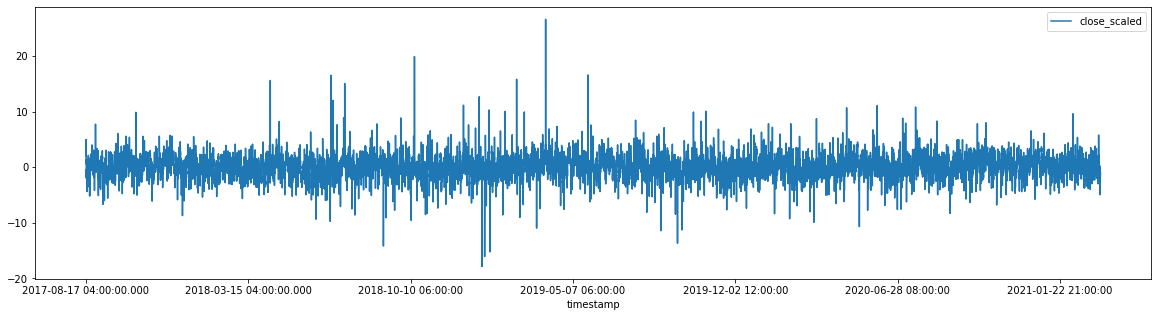

In [132]:
subsample.plot(figsize=(20,5))

In [133]:
subsample.index

Index(['2017-08-17 04:00:00.000', '2017-08-17 05:00:00.000',
       '2017-08-17 06:00:00.000', '2017-08-17 07:00:00.000',
       '2017-08-17 08:00:00.000', '2017-08-17 09:00:00.000',
       '2017-08-17 10:00:00.000', '2017-08-17 11:00:00.000',
       '2017-08-17 12:00:00.000', '2017-08-17 13:00:00.000',
       ...
       '2021-03-15 10:00:00', '2021-03-15 11:00:00', '2021-03-15 12:00:00',
       '2021-03-15 13:00:00', '2021-03-15 14:00:00', '2021-03-15 15:00:00',
       '2021-03-15 16:00:00', '2021-03-15 17:00:00', '2021-03-15 18:00:00',
       '2021-03-15 19:00:00'],
      dtype='object', name='timestamp', length=31245)

#### Train


In [134]:
train_val_size = len(subsample[:"2021-02-15"])
train_val_size

30554

In [135]:
H = 24                      # forecast horizon 24h
N = 24               
pred_day =  30554          # febr 15
train_size = int(train_val_size*0.8)          # 2 years 19, 20
val_size = int(train_val_size*0.2)  

In [136]:
df = edited_data.copy()
df.dropna(inplace = True)

In [137]:
df

,close,close_mean,close_std,close_scaled,close_lag_24_scaled,close_lag_18_scaled,close_lag_12_scaled,close_lag_6_scaled
24,4287.92,4345.897083,67.079253,-0.864307,-0.552586,1.701016,0.123480,-0.135617
25,4313.56,4345.025833,67.714413,-0.464684,-0.438693,1.215017,-0.823840,-0.885274
26,4279.46,4344.952500,67.748927,-0.966694,-0.304101,0.974886,-1.298655,-0.862338
27,4300.25,4343.082083,68.951443,-0.621192,0.100185,1.681153,-0.258908,-1.442930
28,4282.73,4341.009583,69.480280,-0.838793,0.283252,1.868306,0.082475,-1.056697
...,...,...,...,...,...,...,...,...
31240,56224.13,58723.972500,1589.655997,-1.572568,0.602198,0.854001,1.041746,-1.796654
31241,56247.87,58579.925417,1654.453358,-1.409563,0.597064,0.979940,0.721558,-1.344725
31242,56035.79,58441.597500,1706.247346,-1.409999,0.738171,0.308696,0.335094,-1.342600
31243,56113.90,58288.876250,1752.032764,-1.241402,1.055593,0.636748,0.281167,-1.055543


In [138]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))\

train.shape = (24444, 8)
val.shape = (6110, 8)
train_val.shape = (30554, 8)
test.shape = (24, 8)


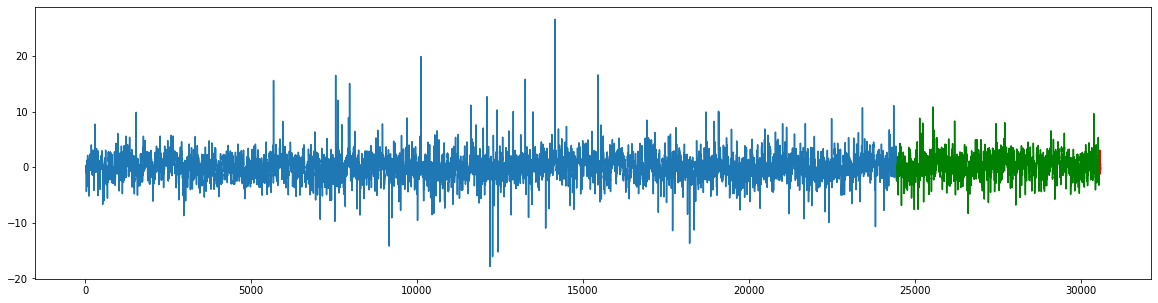

In [140]:
train.close_scaled.plot(figsize=(20,5))
val.close_scaled.plot(figsize=(20,5), c = "green")
test.close_scaled.plot(figsize=(20,5), c = "red")

In [141]:
df.dropna(inplace = True)

In [142]:
df

,close,close_mean,close_std,close_scaled,close_lag_24_scaled,close_lag_18_scaled,close_lag_12_scaled,close_lag_6_scaled
24,4287.92,4345.897083,67.079253,-0.864307,-0.552586,1.701016,0.123480,-0.135617
25,4313.56,4345.025833,67.714413,-0.464684,-0.438693,1.215017,-0.823840,-0.885274
26,4279.46,4344.952500,67.748927,-0.966694,-0.304101,0.974886,-1.298655,-0.862338
27,4300.25,4343.082083,68.951443,-0.621192,0.100185,1.681153,-0.258908,-1.442930
28,4282.73,4341.009583,69.480280,-0.838793,0.283252,1.868306,0.082475,-1.056697
...,...,...,...,...,...,...,...,...
31240,56224.13,58723.972500,1589.655997,-1.572568,0.602198,0.854001,1.041746,-1.796654
31241,56247.87,58579.925417,1654.453358,-1.409563,0.597064,0.979940,0.721558,-1.344725
31242,56035.79,58441.597500,1706.247346,-1.409999,0.738171,0.308696,0.335094,-1.342600
31243,56113.90,58288.876250,1752.032764,-1.241402,1.055593,0.636748,0.281167,-1.055543


In [147]:
rmse_list, mae_list, mape_list, preds_dict, targets, f = multiple_runs(df, train_size, N, H)

  0%|          | 0/563 [00:00<?, ?it/s]



Len features:  4


['close_lag_24_scaled', 'close_lag_18_scaled', 'close_lag_12_scaled', 'close_lag_6_scaled']


100%|██████████| 563/563 [09:29<00:00,  1.01s/it]


In [149]:
import numpy as np

In [157]:
len(mape_list)

563

In [156]:
print(np.mean(mape_list))
print(np.mean(mae_list))
print(np.mean(rmse_list))

1.811790699175631
488.40296248531394
566.2089252265702


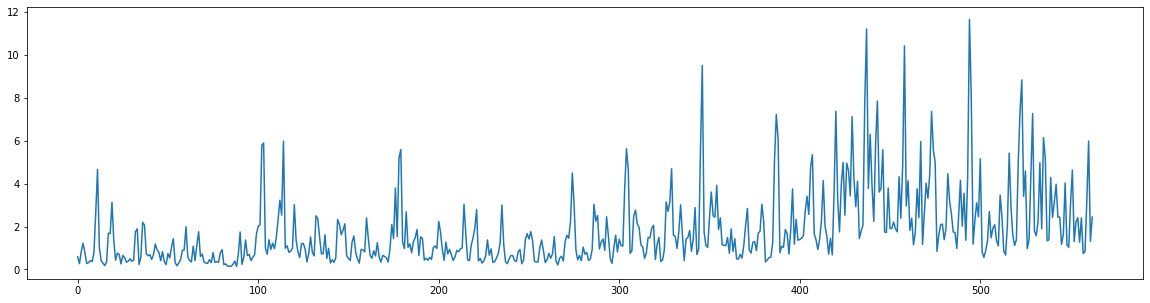

In [160]:
fig = plt.figure(figsize=(20,5))
plt.plot(mape_list)


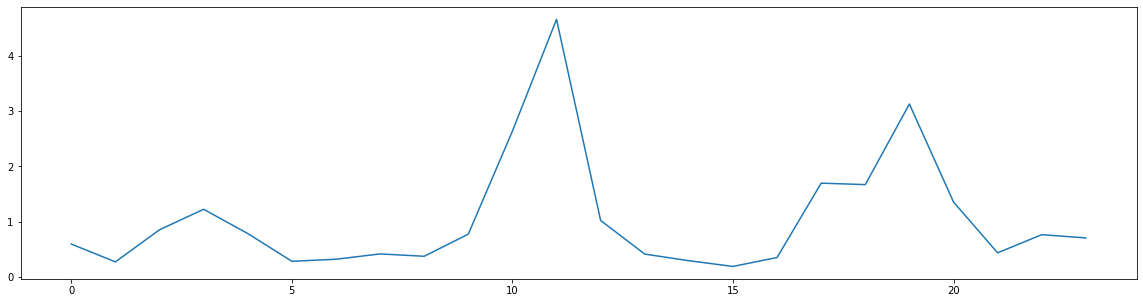

In [161]:
fig = plt.figure(figsize=(20,5))
plt.plot(mape_list[0:24])